In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_csv('.csv/cleaned_data.csv', index_col = 0)
xgb_data = df.copy()
pd.set_option('display.max_column', None)

In [3]:
xgb_data.replace(np.inf, np.nan, inplace=True)

In [4]:
xgb_data['NewExist_Encoded'] = xgb_data['NewExist'].map({1.0 : 1, 2.0: 2, np.nan: 0})
xgb_data['UrbanRural_Encoded'] = xgb_data['UrbanRural'].map({1.0 : 1, 2.0: 2, 0.0: 0}).fillna(0).astype('int64')
xgb_data['MIS_Status_Encoded'] = xgb_data['MIS_Status'].map({'CHGOFF': 0, 'PIF': 1})
xgb_data['RevLineCr_Encoded'] = xgb_data['RevLineCr'].map({'N': 1, 'Y': 2}).fillna(0).astype('int64')
xgb_data['LowDoc_Encoded'] = xgb_data['LowDoc'].map({'N': 0, 'Y': 1})
xgb_data['FranchiseCode_Encoded'] = xgb_data['FranchiseCode_Encoded'].map({'No': 0, 'Yes': 1}).astype('int64')
xgb_data['RealEstate_Backed'] = xgb_data['RealEstate_Backed'].map({'No': 0, 'Yes': 1}).astype('int64')
xgb_data['CreateJob_Encoded'] = xgb_data['CreateJob'].apply(lambda x: 1 if x > 0 else 0)
xgb_data['RetainedJob_Encoded'] = xgb_data['RetainedJob'].apply(lambda x: 1 if x > 0 else 0)
xgb_data['State'] = xgb_data['State'].astype('category')
xgb_data['StateRisk'] = xgb_data['StateRisk'].astype('category')
xgb_data['Region'] = xgb_data['Region'].astype('category')

In [5]:
xgb_data.loc[:, 'EmployeeLoanRatio'] = xgb_data.apply(
    lambda row: round(row['GrAppv']) if pd.isna(row['EmployeeLoanRatio']) else round(row['EmployeeLoanRatio']),
    axis=1
).astype('int64')

In [6]:
xgb_data.drop(labels=['LoanNr_ChkDgt', 'Name', 'City', 'Bank', 'BankState', 'TermDays', 'ApprovalDate', 'ApprovalFY', 'Zip', 'DisbursementDate', 
                      'DisbursementGross','NewExist', 'RetainedJob', 'LowDoc' ,'UrbanRural', 'RevLineCr', 'ChgOffDate',
                      'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'SBA_Appv', 'Industry', 'RetainedJob_Encoded',
                       'ApprovalDateYear', 'ChgOffDateYear', 'ApprovalDateMonth', 'DisbursementDateYear',
                       'LoanDateEnd'], axis=1, inplace=True )

In [7]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'EmployeeLoanRatio', 'FranchiseCode', ]

scaler = StandardScaler()
scaled_numerics = scaler.fit_transform(xgb_data[numerical_features])

xgb_data[numerical_features] = scaled_numerics

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = xgb_data.drop(columns=['MIS_Status_Encoded'])
y = xgb_data['MIS_Status_Encoded']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
import xgboost as xgb

# Define model
xgb_model = xgb.XGBClassifier(booster= 'gbtree', enable_categorical=True,
                          device='cuda', objective='binary:logistic',
                          eval_metric= 'logloss',
                          subsample= 0.8,
                          gamma= 4,
                          colsample_bytree=0.7,
                          max_depth= 25,
                          reg_lambda= 0.1,
                          reg_alpha= 10,
                          n_estimators= 800,
                          learning_rate=0.5)

xgb_model.fit(X_train, y_train)

train_score = xgb_model.score(X_train, y_train)

print("Training Score:", round(train_score, 2))

# Store model parameters in a DataFrame
best_xgb_params = xgb_model.get_params()  # Get model's hyperparameters
best_xgb_params_df = pd.DataFrame([best_xgb_params])

print("Training terminated CSV successfully!")

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:12:55] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Training Score: 0.94
Best parameters saved to CSV successfully!


In [10]:
from sklearn.metrics import classification_report

# Make predictions
xgb_y_pred = xgb_model.predict(X_test)

# Calculate the accuracy
xgb_classification_report = classification_report(y_test, xgb_y_pred)

print(xgb_classification_report)

              precision    recall  f1-score   support

           0       0.85      0.81      0.83     31564
           1       0.96      0.97      0.96    147922

    accuracy                           0.94    179486
   macro avg       0.90      0.89      0.90    179486
weighted avg       0.94      0.94      0.94    179486



In [11]:
from sklearn.model_selection import cross_val_score

# Evaluate model using cross-validation
xgb_roc_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f'ROC-AUC: {round(xgb_roc_scores.mean(),2)}')

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:13:31] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:13:42] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/xgboost/core.py

ROC-AUC: 0.97


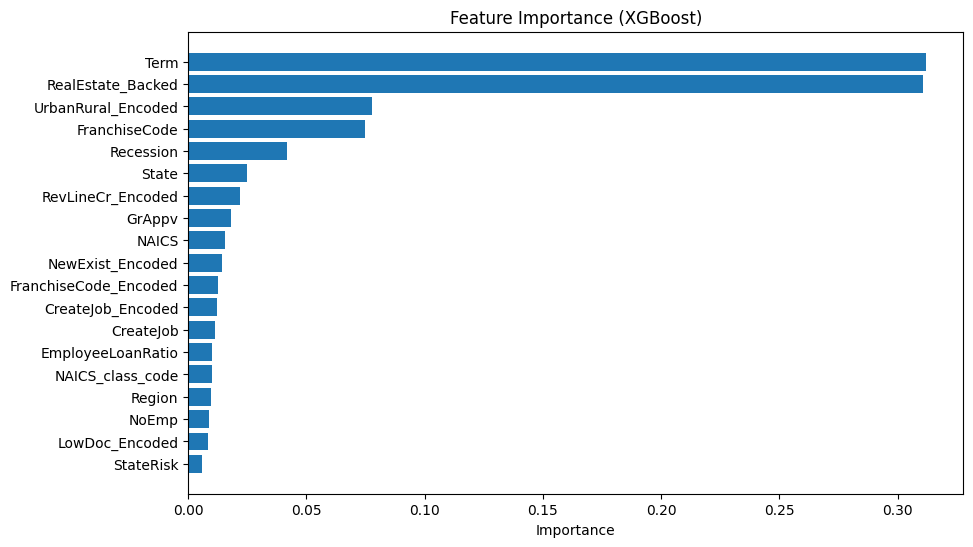

In [14]:
# Vizualize Feature Importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.show()


In [27]:
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include=['bool']).columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include=['bool']).columns})


X_train shape: (717942, 19)
X_test shape: (179486, 19)


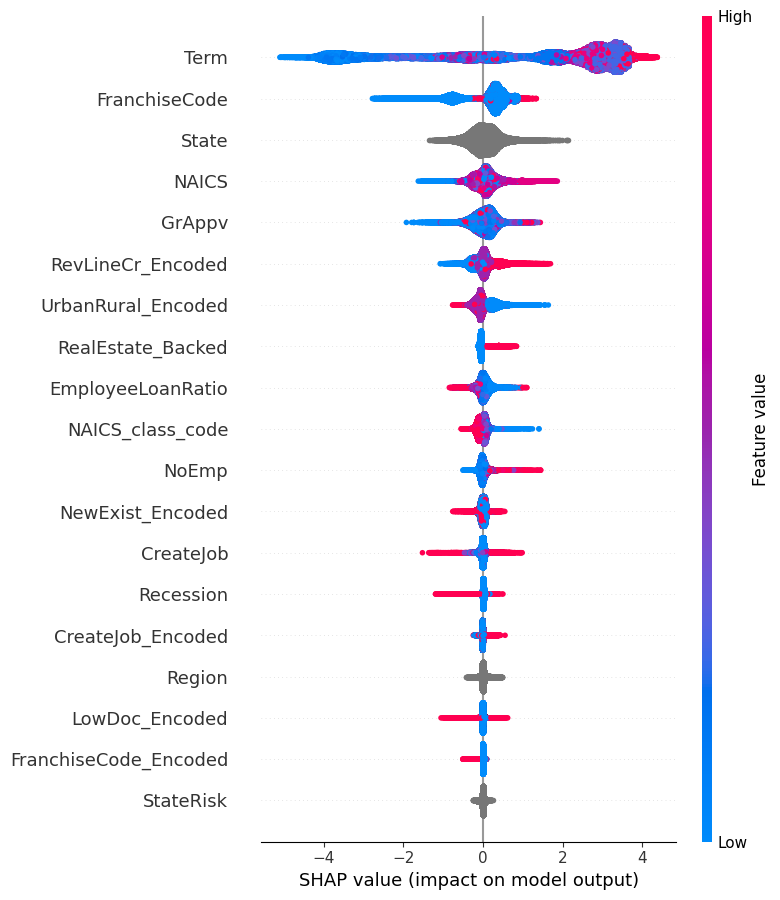

In [13]:
import shap

# Ensure X_test has the same columns as X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Convert boolean columns to integers
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include=['bool']).columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include=['bool']).columns})

# Check for shape mismatches
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Create SHAP Explainer
explainer = shap.TreeExplainer(xgb_model, feature_perturbation="tree_path_dependent")

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Plot Summary
shap.summary_plot(shap_values, X_test)
